# A Study on Customer Feedback of Globe and Smart Users through Twitter

Entico Jocaz, Yap Sashmir

# Executive Summary

Smart and Globe are the two main telecommunication companies in the Philippines. Despite being competitors, the companies target the Filipino market in varying ways. For example, Smart specializes on mobile solutions, on the other hand, Globe offers not only mobile but also home based internet services. The difference of the two companies might be subtle but both are facing the challenges of scaling their customer service. If we check their twitter accounts, it's flooded by aggressive tweets coming from its users regarding different connectivity issues. It's also normal to see unanswered tweets only to be replied after a day or two. 

In this notebook we investigate on the converstaions of the telco giant's subsribers. In order to do this we have gathered tweets from the past 7 days from its customer facing twitter accounts(talk2Globe, SmartCares). The description as to how the data was gathered and cleaned can be found on the other notebook called "Twitter Crawling and Cleaning". 

The notebook is divided into two main sections. The first section contains details as to how the data was treated and transformed for Smart tweets while the second section pertains to the process done for Globe Tweets. Both data underwent the same process which is the following: 

1. Group tweets by parent status id 
* K-means clustering on the data 
* Visualize data through a word cloud 

**Smart Communications** <br>
The results for Smart users reveal that the tweets can be clustered into 8 clusters. The description of these clusters can be found below. 

| Cluster       | Description  | 
| ------------- |:-------------:| 
| bawas load    | users complaining their load was stolen | 
| answer asap   | users who are requesting for replies from customer service support      | 
| happy friday! | users who went to the celine dion concert     | 
| no signal | users complaining about the signal quality| 
| slow internet | users complaining about the slow internet| 
| reply | users who have sent a private message to smart| 
| area issue| users who are asking if their area is affected by network issues|
| lte issue| users who have issues with their lte signal|

**Globe Telecom** <br>
The results for Globe users reveal that the tweets can be clustered into 9 clusters. The description of these clusters can be found below. 

| Cluster       | Description  | 
| ------------- |:-------------:| 
| account plan    | users who have problems regarding their account and postpaid plans| 
| redeem rewards   | users who have problems regarding redeeming reward points| 
| reply asap | users who are requesting for urgent replies from customer service support| 
| slow internet | users complaining about the slow internet| 
| switch smart | users who are planning to switch telecommunication network| 
| address concerns | users who have requesting for follow up| 
| baka pwede maayos| users who are asking for customer assistance|
| wasted time| users whose time were wasted or it took a long time to address their problem at hand|
| respond message| users who are waiting for the response of Globe from their private message|

In [34]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import re
import pyLDAvis.sklearn
from collections import Counter
from PIL import Image
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
import pickle
%matplotlib inline

# Data Preprocessing

Accourding to <a href="https://dam-prod.media.mit.edu/x/files/wp-content/uploads/sites/27/2014/08/topic-modeling-twitter.pdf">Melis D. & Saveski M.</a>, Topic modelling techniques have a hard time clustering microblogs or tweets. The authors cite three reason for this, tweets are short, they are mixed with contextual clues like hashtags and urls and lastly heavy use of nonstandard language(mispellings, emoticons). To remedy this problem, they created a technique called conversation pooling which is a type of tweet pooling method. Conversation pooling means combining all tweet replies to a single document while treating those that dont have replies as a lone document. 

In this part we group our tweets based on its parent id and merged these to form a single document. Tweets that dont have a parent id were considered a single document of its own which follows the method of conversation pooling.

In [47]:
def group_tweets_by_parent_status_id(df):
    return df.groupby('in_reply_to_status_id')['tweet'].agg(lambda col: ' '.join(col)).tolist()

In [636]:
smart_eng = pd.read_csv('smart_eng_cleaned.csv')
smart_eng.drop(smart_eng.columns[0], axis=1, inplace=True)
smart_eng = smart_eng[pd.notnull(smart_eng['tweet'])]
smart_eng = smart_eng[~smart_eng.user.isin(['SMARTCares', 'LiveSmart', 'CignalTV', 'PLDT_Cares'])]

smart_fil = pd.read_csv('smart_fil_cleaned.csv')
smart_fil.drop(smart_fil.columns[0], axis=1, inplace=True)
smart_fil = smart_fil[pd.notnull(smart_fil['tweet'])]
smart_fil = smart_fil[~smart_fil.user.isin(['SMARTCares', 'LiveSmart', 'CignalTV', 'PLDT_Cares'])]

smart_eng_tweets = group_tweets_by_parent_status_id(smart_eng)
smart_fil_tweets = group_tweets_by_parent_status_id(smart_fil)
smart_tweets = smart_fil_tweets + smart_eng_tweets \
               + list(smart_eng[smart_eng['in_reply_to_status_id'].isnull()]['tweet']) \
               + list(smart_fil[smart_fil['in_reply_to_status_id'].isnull()]['tweet'])

smart_eng.head()

,tweet_id,created_at,lang,user,in_reply_to_status_id,tweet
0,1019043270888906753,Tue Jul 17 02:17:03 +0000 2018,en,weedburn,NaN,got free youtube wont play internet
3,1019050188252446720,Tue Jul 17 02:44:32 +0000 2018,en,weedburn,NaN,look doing good internet
4,1019050526367870977,Tue Jul 17 02:45:53 +0000 2018,en,RemLampa,NaN,really love
6,1019126397749456896,Tue Jul 17 07:47:22 +0000 2018,en,dannyboy_833,NaN,lte just afternoon just lte
7,1019135582734204928,Tue Jul 17 08:23:52 +0000 2018,en,nonvitaminA,NaN,your team great network support team annoying ...


In [114]:
globe_eng = pd.read_csv('globe_eng_cleaned.csv')
globe_eng.drop(globe_eng.columns[0], axis=1, inplace=True)
globe_eng = globe_eng[~globe_eng.screen_name.isin(['enjoyGLOBE', 'talk2GLOBE',
                                                   'CignalTV', 'PLDT_Cares'])]
globe_eng['tweet'] = globe_eng['tweet'].astype('str')
dummy = globe_eng.groupby('in_reply_to_status_id')['tweet'].sum().reset_index()
globe_eng.in_reply_to_status_id = globe_eng.in_reply_to_status_id.fillna(0)
zeros_eng = globe_eng[globe_eng.in_reply_to_status_id == 0]
zeros_eng = zeros_eng[['in_reply_to_status_id', 'tweet']]
globe_eng = dummy.append(zeros_eng)

globe_fil = pd.read_csv('globe_fil_cleaned.csv')
globe_fil.drop(globe_fil.columns[0], axis=1, inplace=True)
globe_fil = globe_fil[~globe_fil.screen_name.isin(['enjoyGLOBE', 'talk2GLOBE',
                                                   'CignalTV', 'PLDT_Cares'])]
globe_fil['tweet'] = globe_fil['tweet'].astype('str') 
dummy1 = globe_fil.groupby('in_reply_to_status_id')['tweet'].sum().reset_index()
globe_fil.in_reply_to_status_id = globe_fil.in_reply_to_status_id.fillna(0)
zeros_fil = globe_fil[globe_fil.in_reply_to_status_id == 0]
zeros_fil = zeros_fil[['in_reply_to_status_id', 'tweet']]
globe_fil = dummy1.append(zeros_fil)

globe_tweets = globe_eng.append(globe_fil)
globe_tweets.head()

,in_reply_to_status_id,tweet
0,2.703177e+17,tried morning txt msg exceeding
1,6.208495e+17,ur tweet came got missed earlier
2,9.901892e+17,maybe using fully details immediate action
3,1.001453e+18,does apply prepaid tm
4,1.001593e+18,reliable fast month havent solution job 391265...


# Data Exploration

In this section we use TF-IDF frequency to check what are the most and least weighted words in the corpus. We are implementing TF-IDF Vectorizer to transform the tweets into document frequency and the weights of every words are computed based on how many times each word appears in the corpus. TF-IDF adjust to the fact that some words appear more frequent compared to others in general. Furthermore, we removed all the stop words and some words that are related to events hosted by Globe when the data was scraped on Twitter since it may affect the results of the analysis. The ngram used is from 1 to 2 so that we could get more context on words that occur more often together. 

In [8]:
def plot_top_words(tfidf, top_n=15):
    sum_words = tfidf.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=False)

    weights = [word_freq[1] for word_freq in words_freq[-top_n:]]
    labels = [word_freq[0] for word_freq in words_freq[-top_n:]]
    y_pos = np.arange(len(labels))

    fig, ((ax1, ax2)) = plt.subplots(1, 2)
    fig.set_size_inches(18,5)
    ax1.barh(y_pos, weights, align='center',
            color='#E8AA14', ecolor='black')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    ax1.set_title('Top Weighted Words: ')

    weights = [word_freq[1] for word_freq in words_freq[:top_n]]
    labels = [word_freq[0] for word_freq in words_freq[:top_n]]
    y_pos = np.arange(len(labels))

    ax2.barh(y_pos, weights, align='center',
            color='#573D1C', ecolor='black')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.set_title('Least Weighted Words: ')

## Smart Telecommunications


### Smart English Tweets

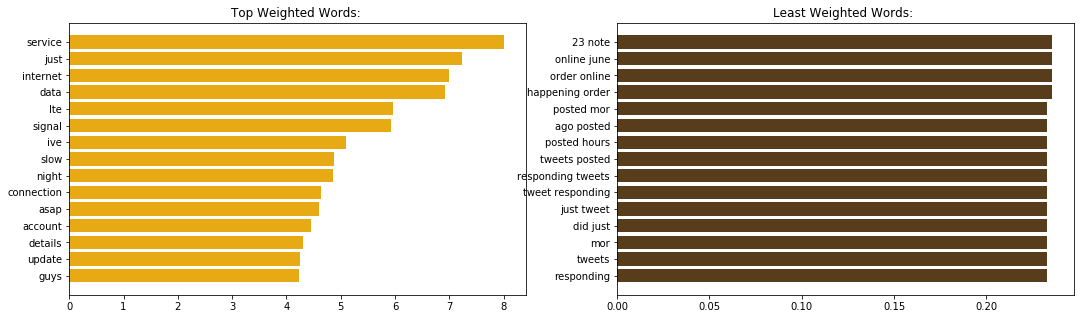

In [655]:
stop_words = text.ENGLISH_STOP_WORDS.union(['smartmusiclive', 'smartcelinedion', 
                                            'dm', 'rt', 'hi', 'hello', 
                                            'smart', 'youve', 'celine', 
                                            'livesmart', 'smartcares'])

# min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
# max_df = 0.2  means "ignore terms that appear in more than 20% of the documents".
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))
smart_eng_tfidf = vectorizer.fit_transform(smart_eng['tweet'])
plot_top_words(smart_eng_tfidf)

Checking the top weighted words of the english tweets, it is observed that the words are mostly related to network related terms(lte, signal, data, internet). Least weighted words on the other hand doesn't give much info except it's about tweet response. 

### Smart Filipino Tweets

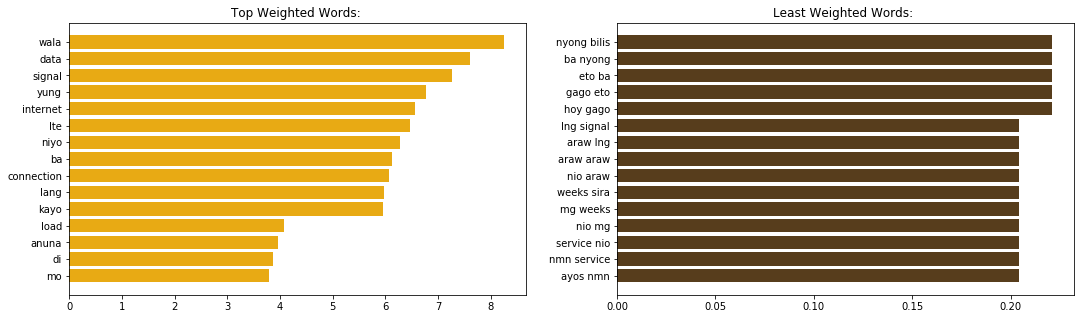

In [656]:
smart_fil_tfidf = vectorizer.fit_transform(smart_fil['tweet'])
plot_top_words(smart_fil_tfidf)

The top and least weighted words for the Filipino tweets seem to be about network issues(data, lte, internet) and the frequency(araw araw, weeks, ngayon) of these issues.

### Smart All Tweets

We merge the Filipino and English tweets. This will be used later for clustering.

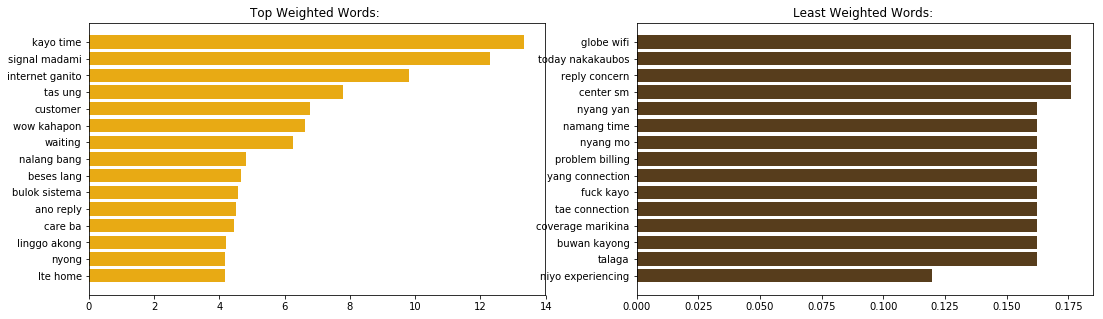

In [660]:
smart_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))
smart_tfidf = smart_vectorizer.fit_transform(smart_tweets)
plot_top_words(smart_tfidf)

The same trend can be noticed which is words about network issues.

### Smart SVD Plot 

We plot the tweets using SVD in order to see if it was possible to glimpse clusters.

Text(0,0.5,'component 2')

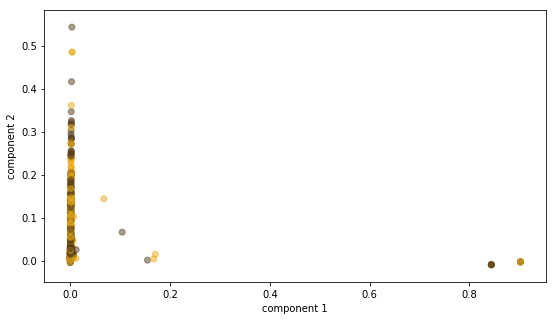

In [642]:
svd = TruncatedSVD(n_components=2)
smart_svd = svd.fit_transform(smart_tfidf)

plt.figure(figsize=(9,5))
plt.scatter(smart_svd[:, 0], smart_svd[:, 1], c=['#E8AA14', '#573D1C'],
            alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')

There are no obvious clusters that can be noticed but it is important to note that we only used 2 components to explain the dataset that we have which might not be enough information to see the clusters.

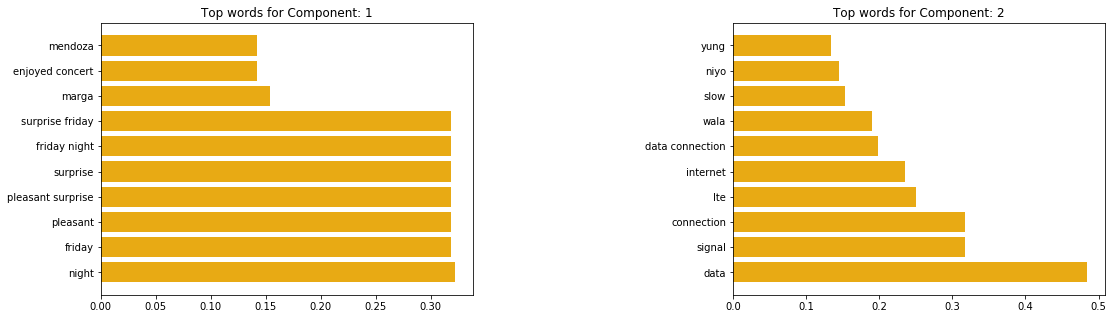

In [643]:
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=.7, wspace=.7)
for idx, topic in enumerate(svd.components_[:9]):
    indexes = topic.argsort()[:-10 - 1:-1]
    labels = [(smart_vectorizer.get_feature_names()[i]) for i in indexes]
    weights =  [(topic[i]) for i in indexes]
    y_pos = np.arange(len(labels))
    
    ax = fig.add_subplot(1, 2, idx+1)
    ax.barh(y_pos, weights, align='center',
        color='#E8AA14', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_title('Top words for Component: ' + str(idx+1))


Component 1 seems to be about the celine dion concert while component 2 is on network issues.

## Globe Telecom

For Globe users/customers, we are scraping the tweets that are addressed to the official twitter account of Globe **@talk2GLOBE** that is specifically created for concerns and feedbacks. The tweets scraped from the Twitter API are in English and Tagalog language that represents majority of the customers which are then merged for clustering analysis.

### Globe English Tweets

In [109]:
stop_words = text.ENGLISH_STOP_WORDS.union(['dm', 'rt', 'hi', 'hello', 
                                            'globe', 'enjoyglobe', 'hiphop',
                                            'talk2globe', 'hiphopcollab',
                                            'vote', 'rapbattle', 'petersburg',
                                            'mashup', 'wannaone'])

vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))

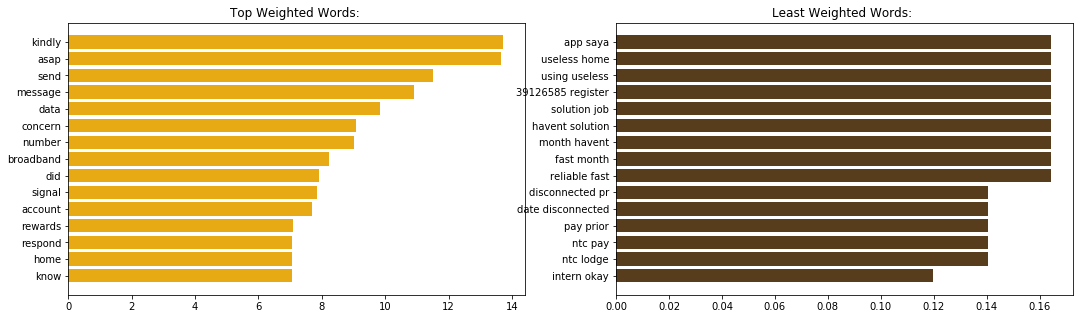

In [26]:
globe_eng_tfidf = vectorizer.fit_transform(globe_eng['tweet'])
plot_top_words(globe_eng_tfidf)

The most weighted words for the Globe English tweets are composed of requests of different users directed to Globe to answer their inquiries, questions, and problems regarding their account. On the other hand, the least weighted words for the Globe English tweets are composed of words that is connected to the internet connection of Globe users.

### Globe Filipino Tweets

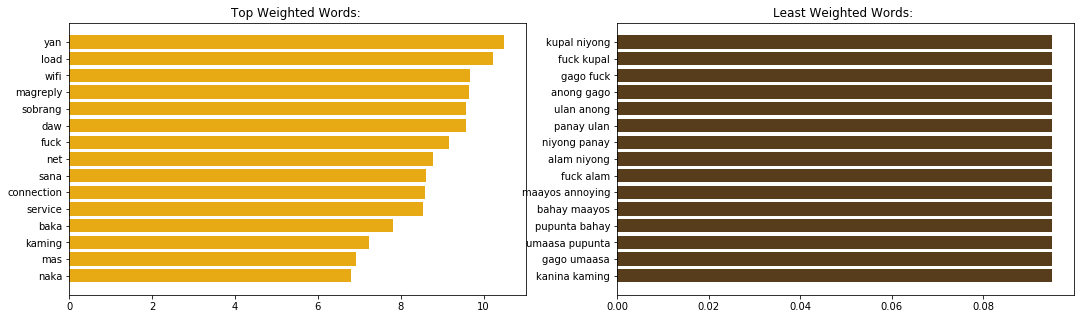

In [27]:
globe_fil_tfidf = vectorizer.fit_transform(globe_fil['tweet'])
plot_top_words(globe_fil_tfidf)

The most weighted words for the Globe Filipino tweets are composed of words that is related to the internet connection of Globe users. On the other hand, the least weighted words for the Globe Filipino tweets are composed of users who bad-mouthed Globe because of their services.

### Globe All Tweets

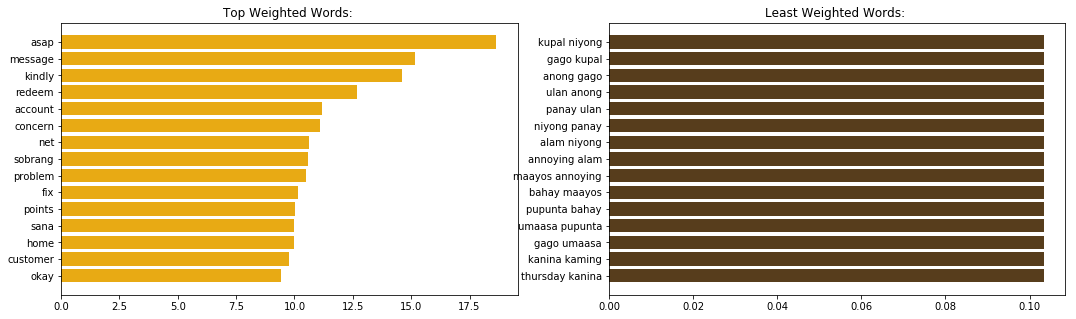

In [44]:
globe_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))
globe_tfidf = globe_vectorizer.fit_transform(globe_tweets['tweet'])
plot_top_words(globe_tfidf)

After combining the tweets, the most weighted words are composed of requests of customer assistance while the least weighted words are composed of dissatisfied comments on Globe services.

### Globe SVD Plot

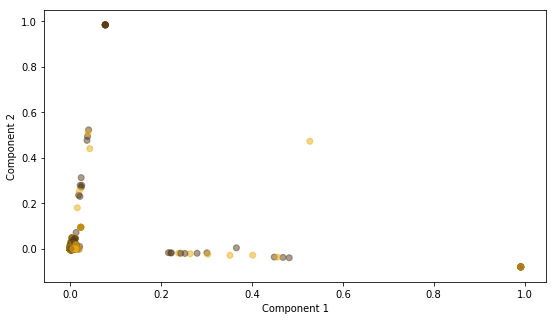

In [29]:
svd = TruncatedSVD(n_components=2)
globe_svd = svd.fit_transform(globe_tfidf)

plt.figure(figsize=(9,5))
plt.scatter(globe_svd[:, 0], globe_svd[:, 1], c=['#E8AA14', '#573D1C'],
            alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2');

# Clustering Time!

### Determining the Optimal Number of Clusters

To determine the optimal number of clusters, we are following the three internal validation criteria namely, Sum of squares distances to centroids (SSE), Intracluster to intercluster distance ratio, and Silhouette coefficient.
- SSE: We are minimizing the sum of squares distance of the representative points between clusters.
- Intracluster to intercluster distance ratio: We are taking the ratio of the average distance of points within clusters and the average distance between pairs of clusters. Smaller ratio indicates better clustering.
- Silhouette coefficient: Higher values of silhouette coefficient shows that the clustering is good.

In [31]:
def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio
    
    Parameters
    ----------
    X : array
        Data matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample
        
    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """
    dist_P = []
    dist_Q = []
#     np.random.seed(11)
    for i, j in np.random.randint(low=0, high=len(y), size=[r,2]):
        # just skip the pair even if we end up having pairs less than r
        if i == j:
            continue
        # intracluster
        elif y[i] == y[j]:
            dist_P.append(dist(X[i], X[j]))
        # intercluster
        else:
            dist_Q.append(dist(X[i], X[j]))
    intra = np.sum(dist_P) / len(dist_P)
    inter = np.sum(dist_Q) / len(dist_Q)
    ratio = intra / inter
    return ratio

## Smart Telecommunications

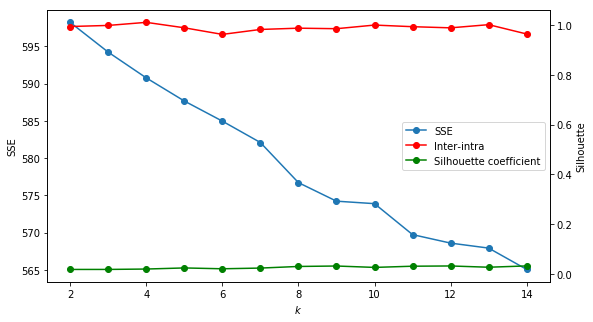

In [644]:
inertias = []
iidrs = []
scs = []
cluster_min = 2
cluster_max = 15
for i in range(cluster_min, cluster_max):
    kmeans = KMeans(n_clusters=i)
    y = kmeans.fit_predict(smart_tfidf)
    inertias.append(kmeans.inertia_)
    iidrs.append(intra_to_inter(smart_tfidf.todense(), y, euclidean, 50))
    scs.append(silhouette_score(smart_tfidf.todense(), y))

plt.figure(figsize=(9,5))
plt.plot(np.arange(cluster_min,cluster_max), inertias, '-o', label='SSE')
plt.xlabel('$k$')
plt.ylabel('SSE')
lines, labels = plt.gca().get_legend_handles_labels()
plt.twinx()
plt.plot(np.arange(cluster_min,cluster_max), iidrs, '-ro', label='Inter-intra')
plt.plot(np.arange(cluster_min,cluster_max), scs, '-go', label='Silhouette coefficient')
plt.ylabel('Silhouette')
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(lines+lines2, labels+labels2);

We plot the sum of squares error, inter-intra ratio and silhouette coefficient in order to gain insight as to how many clusters to use. SSE seems to be the only thing that is useful since the other 2 metrics are linear. We choose 8 in this case since it forms some sort of elbow on that point.

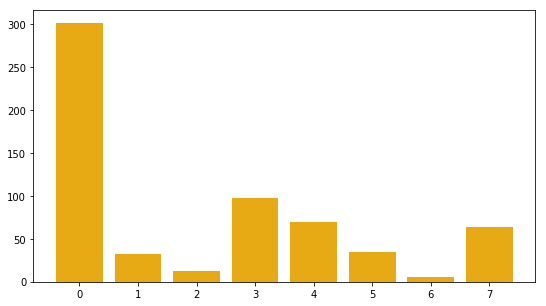

In [645]:
kmeans = KMeans(n_clusters=8, max_iter=5000)
y = kmeans.fit_predict(smart_tfidf)

cluster_count_tuple = sorted(Counter(y).items())
cluster, count = zip(*cluster_count_tuple)

plt.figure(figsize=(9,5))
plt.bar(range(kmeans.n_clusters), count, color='#E8AA14')
plt.show()

Running K-means, We plot the counts per cluster, 1 has the highest number of tweets while 6 has the lowest. Side note, k-means is a famous clustering algorithm that clusters words based on distance to the nearest centroid. 

In [646]:
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
terms = smart_vectorizer.get_feature_names()
df_clusters = pd.DataFrame()

for i in range(kmeans.n_clusters):
    df_clusters['Cluster '+str(i)] = pd.Series([terms[j] for j in order_centroids[i, :10]])
df_clusters

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7
0,update,just,surprise,data,internet,kayo,todays,lte
1,load,asap,pleasant surprise,signal,service,si,sona commonwealth,yung
2,details,answer asap,pleasant,connection,slow,reply,nosignal,wifi
3,account,hotline,surprise friday,data connection,slow internet,ano,nosignal area,signal
4,dear,need,friday,wala,happening,yung,commonwealth culiat,ba
5,lang,just lte,friday night,niyo,customer service,kayo time,commonwealth,naka
6,response,answer,night,internet connection,whats happening,wala,clarification scope,home
7,hey,just tried,mendoza,internet,customer,niyo,scope nosignal,naka lte
8,plan,tried,vargas,area,whats,ba,scope,ba yung
9,hours,understand,vargas arjie,nang,speed,time,culiat,home wifi


We try to get a glimpse as to what the different clusters mean but a more powerful visualization could be used so we use a word cloud. The code below was heavily inspired from the work of <a href='https://github.com/ewellinger/election_analysis/tree/0e8f6a5c7149765bbc7b6a62b18a01843b9b7ec9'>ewllinger</a> 

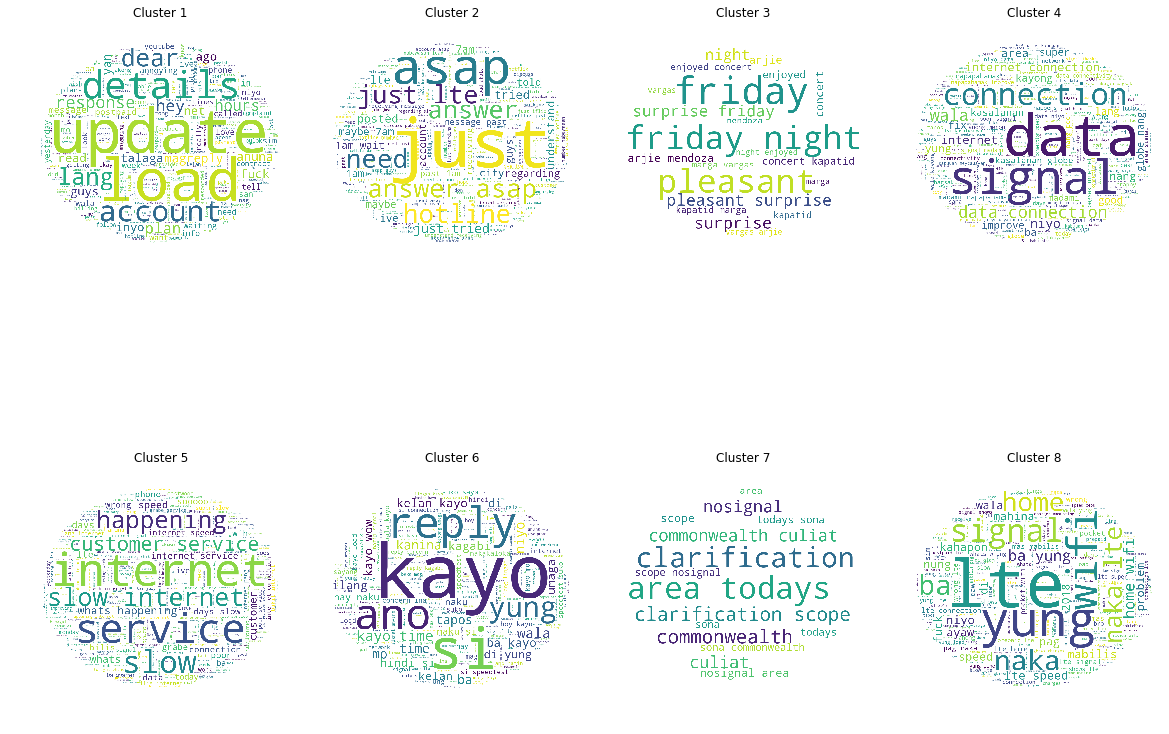

In [659]:
def topic_word_freq(clusters, idx, feature_names):
    freq_sum = np.sum(clusters[idx])
    frequencies = [val / freq_sum for val in clusters[idx]]
    freq_dict = dict(zip(feature_names, frequencies))
    return { k:v for k, v in freq_dict.items() if v }

ellipse_mask = np.array(Image.open("ellipse_mask.png"))
wc = WordCloud(background_color='white', max_words=300, width=1500, height=1500, mask=ellipse_mask, scale=2)

fig = plt.figure(figsize=(20,15))
for idx in range(kmeans.n_clusters):
    word_freq = topic_word_freq(kmeans.cluster_centers_, idx, smart_vectorizer.get_feature_names())
    wc.fit_words(word_freq)
    ax = fig.add_subplot(2, 4, idx+1)
    ax.imshow(wc)
    ax.set_title('Cluster ' + str(idx+1))
    ax.axis('off')
    

## Globe Telecom

C:\Users\JocazAyrand\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


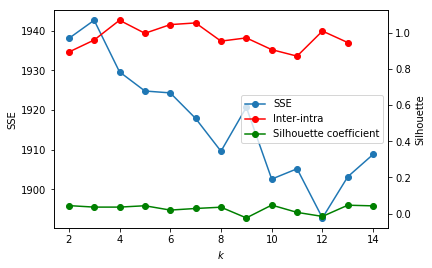

In [33]:
inertias = []
iidrs = []
scs = []
cluster_min = 2
cluster_max = 15
for i in range(cluster_min, cluster_max):
    kmeans = KMeans(n_clusters=i)
    y = kmeans.fit_predict(globe_tfidf)
    inertias.append(kmeans.inertia_)
    iidrs.append(intra_to_inter(globe_tfidf.values, y, euclidean, 50))
    scs.append(silhouette_score(globe_tfidf, y))

plt.plot(np.arange(cluster_min,cluster_max), inertias, '-o', label='SSE')
plt.xlabel('$k$')
plt.ylabel('SSE')
lines, labels = plt.gca().get_legend_handles_labels()
plt.twinx()
plt.plot(np.arange(cluster_min,cluster_max), iidrs, '-ro', label='Inter-intra')
plt.plot(np.arange(cluster_min,cluster_max), scs, '-go', label='Silhouette coefficient')
plt.ylabel('Silhouette')
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(lines+lines2, labels+labels2);

We can observe that the Silhouette coefficient plateau at a certain level throughout the values of k. Moreover, there is a sudden decrease in the SSE and Inter-intra criterion at $k=9$. Thus, the optimal number of neighbors to be used in K-Means Clustering is $k=9$.

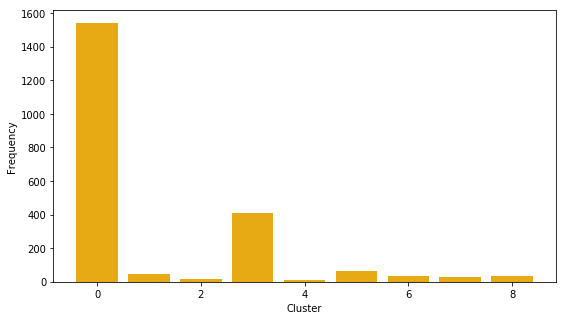

In [35]:
kmeans = KMeans(n_clusters=9)
y = kmeans.fit_predict(globe_tfidf)

cluster_count_tuple = sorted(Counter(y).items())
cluster, count = zip(*cluster_count_tuple)

plt.figure(figsize=(9,5))
plt.bar(range(kmeans.n_clusters), count, color='#E8AA14')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

Majority of the tweets are clustered in two clusters which are **Cluster 0** and **Cluster 3**. The other clusters have minimal difference in the frequency of tweets.

In [37]:
order_centroids = loaded_model.cluster_centers_.argsort()[:,::-1]
terms = vectorizer.get_feature_names()
df_clusters = pd.DataFrame()

for i in range(kmeans.n_clusters):
    df_clusters['Cluster '+str(i)] = pd.Series([terms[j] for j in order_centroids[i, :10]])
df_clusters

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
0,account,redeem,asap,sobrang,smart,kindly,baka,time,message
1,customer,points,kindly asap,net,smart jusko,concern,pwede,problem time,got message
2,plan,reward,paki asap,okay,switch smart,email,maayos,waste time,receive message
3,problem,redeem points,telco asap,magreply,switch,address,araw,waste,got
4,fix,reward points,pakicheck asap,week,change sim,details,baka kaming,problem,message kindly
5,waiting,redeem gift,asap grrr,did,sim smart,offer condo,sumagot chats,sana,respond
6,know,app,grrr,mas,jusko,offer,niyong sumagot,result,receive
7,text,use points,pakicheck,respond,app,dmci homes,chats,sagot,response
8,phone,use,telco,home,inconvenience smart,homes offer,chats calls,ayan time,message asking
9,puro,gift,paki,weeks,smart emergency,owners,baka niyong,time gago,message respond


These are the top 10 words that were used to determine where the tweets should be clustered. These words can be used to generalize each clusters and determine the characteristics and behavior of different tweets.

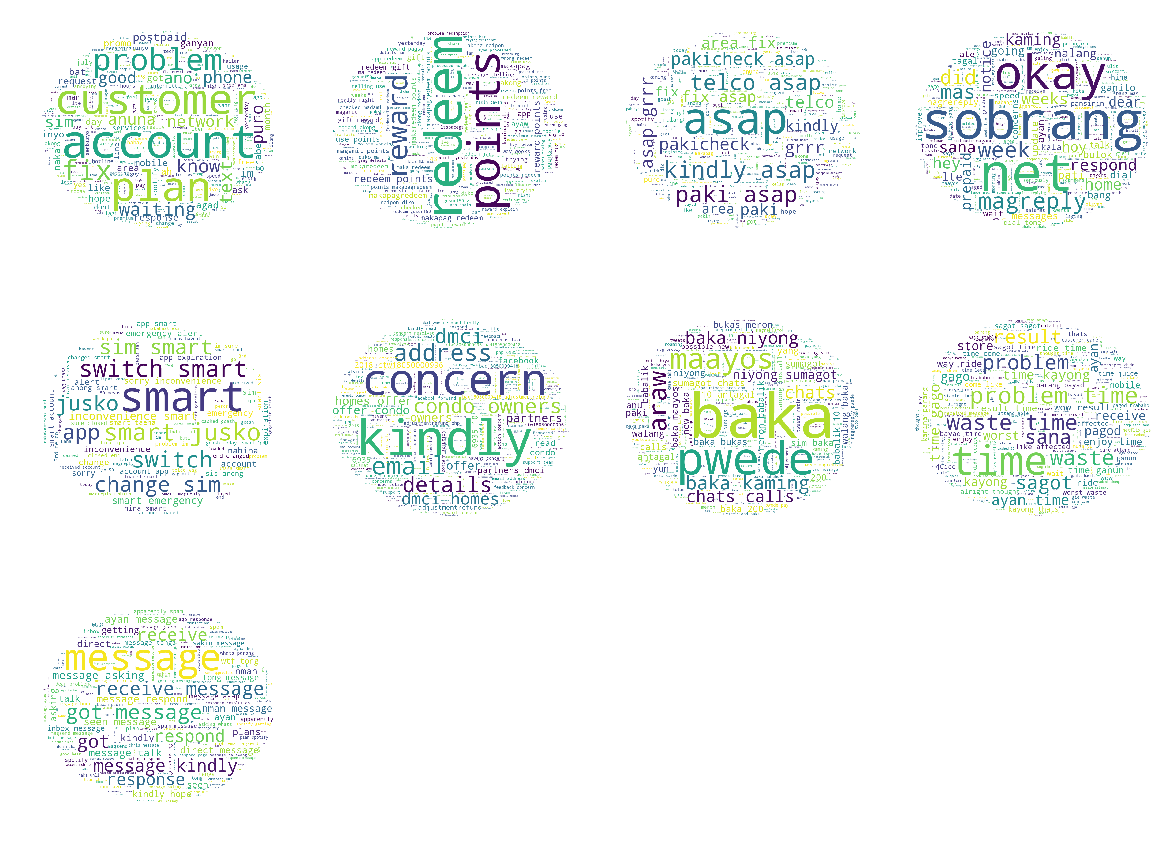

In [41]:
def topic_word_freq(clusters, idx, feature_names):
    freq_sum = np.sum(clusters[idx])
    frequencies = [val / freq_sum for val in clusters[idx]]
    freq_dict = dict(zip(feature_names, frequencies))
    return { k:v for k, v in freq_dict.items() if v }

ellipse_mask = np.array(Image.open("ellipse_mask.png"))
wc = WordCloud(background_color='white', max_words=300, width=1500, height=1500, mask=ellipse_mask, scale=2)

fig = plt.figure(figsize=(20,15))
for idx in range(kmeans.n_clusters):
    word_freq = topic_word_freq(kmeans.cluster_centers_, idx, vectorizer.get_feature_names())
    wc.fit_words(word_freq)
    ax = fig.add_subplot(3, 4, idx+1)
    ax.imshow(wc)
    ax.axis('off')

### Results
**Smart Telecommunications** <br>
A summary of the different clusters and its description can be found below. 

| Cluster       | Description  | 
| ------------- |:-------------:| 
| bawas load    | users complaining their load was stolen | 
| answer asap   | users who are requesting for replies from customer service support      | 
| happy friday! | users who went to the celine dion concert     | 
| no signal | users complaining about the signal quality| 
| slow internet | users complaining about the slow internet| 
| reply | users who have sent a private message to smart| 
| area issue| users who are asking if their area is affected by network issues|
| lte issue| users who have issues with their lte signal|

It can be observed that the central themes of the different clusters are network issues, celine dion concert and response follow ups. There are overlaps on reponse follow ups since it can be found on clusters 1, 2 and 6. Clusters 6 and 8, are kind of the same since it talks about mobile signal issues. 

**Globe Telecom** <br>
Based on the results of k-means clustering, the tweets directed to **Globe Twitter Account** can be clustered into 9 groups. The description of the clusters is as follows:

| Cluster       | Description  | 
| ------------- |:-------------:| 
| account plan    | users who have problems regarding their account and postpaid plans| 
| redeem rewards   | users who have problems regarding redeeming reward points| 
| reply asap | users who are requesting for urgent replies from customer service support| 
| slow internet | users complaining about the slow internet| 
| switch smart | users who are planning to switch telecommunication network| 
| address concerns | users who have requesting for follow up| 
| baka pwede maayos| users who are asking for customer assistance|
| wasted time| users whose time were wasted or it took a long time to address their problem at hand|
| respond message| users who are waiting for the response of Globe from their private message|

We can observe that most of the tweets are mostly composed of customer assistance regarding connectivity issues. There is a cluster that consist of dissatisfied customers who are willing to switch to another network because of the unresolved issues. If there is no action taken, there is a possibility of losing market shares that will greatly impact the company's overall revenue and performance.

Overall, it can be observed that both Globe and Smart users have the same sentiments. It can be broken down into 3 themes, network issues, customer assistance, and follow up requests. 

## Recommendation
In order to address every concern effectively and efficiently, we recommend to use reply templates to specific issues at hand depending on the cluster result. In this case, if the tweet contains specific set of words, the company could reply almost instantly to address the concerns of their customers. For example if a customer would ask regarding rewards redemption a bot could easily send a link to a webpage as to how to do this. This would lead to better customer experience and at the same time reduce the work load to be done by the company. In effect, this gives the company a more optimized business process.

# References

https://github.com/ewellinger/election_analysis/tree/0e8f6a5c7149765bbc7b6a62b18a01843b9b7ec9

https://github.com/amueller/word_cloud